# PsychohistoryML: Equinox 2022 Replication Study

**Objective**: Validate findings from the 2017 Seshat dataset (n=114) on the larger Equinox 2022 dataset (n=373+). Test whether complexity-instability patterns replicate with more data.

## Research Questions
1. **Replication**: Do complexity-duration patterns hold on larger sample?
2. **Robustness**: Is instability prediction accurate with expanded data?
3. **Non-linearity**: Does PC1² remain a dominant predictor?
4. **Improvement**: Will larger n improve model performance?

## Key Updates from Notebook 03
- **Instability** (not "collapse"): Duration < 33rd percentile (~146 years)
- **Non-linear models prioritized**: XGBoost >> Logistic Regression
- **Cleaner evaluation**: Focus on AUC, not just accuracy

## Definition of "Instability"
We define instability as polities with duration < 33rd percentile. This captures genuinely short-lived polities (~3-4 generations) while acknowledging we lack true collapse mechanism data.

---
## 1. Setup & Environment

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Core ML
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (r2_score, mean_squared_error, mean_absolute_error, roc_curve, roc_auc_score, 
                             accuracy_score, classification_report, confusion_matrix)
import statsmodels.api as sm

# XGBoost
try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except ImportError:
    HAS_XGB = False

# Settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 5)
Path("figures").mkdir(exist_ok=True)
Path("models").mkdir(exist_ok=True)

print(f"✓ Setup complete | XGBoost: {HAS_XGB}")

✓ Setup complete | XGBoost: True


---
## 2. Load Equinox 2022 Dataset

The Equinox dataset has a different structure than the 2017 release:
- **Format**: Long (one row per variable per polity) vs 2017's wide format
- **Size**: 47,477 observations across 373 polities
- **Sections**: 6 data categories (we focus on "Social Complexity variables")
- **Columns**: `NGA`, `Polity`, `Section`, `Variable`, `Value.From`, `Date.From`, etc.

In [15]:
# Load Equinox dataset
equinox_path = "../data/Equinox_on_GitHub_June9_2022.xlsx"
df_raw = pd.read_excel(equinox_path, sheet_name='Equinox2020_CanonDat')

print(f"✓ Loaded Equinox 2022 dataset")
print(f"  Total rows: {len(df_raw):,}")
print(f"  Columns: {df_raw.columns.tolist()}")
print(f"  Unique polities: {df_raw['Polity'].nunique()}")
print(f"  Unique NGAs: {df_raw['NGA'].nunique()}")

# Show data structure
print("\nSample rows:")
display(df_raw.head(10)[['NGA', 'Polity', 'Section', 'Variable', 'Value.From']])

✓ Loaded Equinox 2022 dataset
  Total rows: 47,477
  Columns: ['NGA', 'Polity', 'Section', 'Subsection', 'Variable', 'Value.From', 'Value.To', 'Date.From', 'Date.To', 'Fact.Type', 'Value.Note', 'Date.Note']
  Unique polities: 373
  Unique NGAs: 35

Sample rows:


,NGA,Polity,Section,Variable,Value.From
0,Kachi Plain,AfDurrn,General variables,RA,Stephen Dean
1,Kachi Plain,AfDurrn,General variables,RA,Alice Williams
2,Kachi Plain,AfDurrn,General variables,Original name,Durrani Empire
3,Kachi Plain,AfDurrn,General variables,Alternative names,Sadozai Kingdom
4,Kachi Plain,AfDurrn,General variables,Alternative names,Last Afghan Empire
5,Kachi Plain,AfDurrn,General variables,Peak Date,1761 CE
6,Kachi Plain,AfDurrn,General variables,Duration,1747-1826 CE
7,Kachi Plain,AfDurrn,General variables,Degree of centralization,loose
8,Kachi Plain,AfDurrn,General variables,Supra-polity relations,none
9,Kachi Plain,AfDurrn,General variables,preceding (quasi)polity,Afsharid Dynasty


In [17]:
# Examine sections
print("Data sections available:")
section_counts = df_raw['Section'].value_counts()
for section, count in section_counts.items():
    pct = 100 * count / len(df_raw)
    print(f"  {section:45s}: {count:6,} rows ({pct:5.1f}%)")

# Focus on social complexity
sc_data = df_raw[df_raw['Section'] == 'Social Complexity variables'].copy()
print(f"\n✓ Filtered to Social Complexity variables: {len(sc_data):,} rows")
print(f"  Unique polities with SC data: {sc_data['Polity'].nunique()}")
print(f"  Unique SC variables: {sc_data['Variable'].nunique()}")

Data sections available:
  Warfare variables                            : 18,140 rows ( 38.2%)
  Social Complexity variables                  : 16,806 rows ( 35.4%)
  Religion and Normative Ideology              :  6,053 rows ( 12.7%)
  General variables                            :  5,567 rows ( 11.7%)
  Institutional Variables                      :    572 rows (  1.2%)
  Social Mobility                              :    339 rows (  0.7%)

✓ Filtered to Social Complexity variables: 16,806 rows
  Unique polities with SC data: 373
  Unique SC variables: 52


---
## 3. Core Hierarchy Variables

We need the same 4 variables used in the 2017 analysis:
1. Settlement hierarchy
2. Administrative levels
3. Religious levels
4. Military levels

In [18]:
# Check which variables are available
print("Top 20 Social Complexity variables by observation count:")
var_counts = sc_data['Variable'].value_counts().head(20)
for var, count in var_counts.items():
    print(f"  {var:60s}: {count:4,} obs")

# Our target variables
hierarchy_vars = [
    'Settlement hierarchy',
    'Administrative levels',
    'Military levels',
    'Religious levels'
]

# Check coverage
print("\n" + "="*80)
print("TARGET HIERARCHY VARIABLES (from 2017 analysis)")
print("="*80)
for var in hierarchy_vars:
    count = (sc_data['Variable'] == var).sum()
    if count > 0:
        print(f"✓ {var:30s}: {count:4,} observations")
    else:
        print(f"✗ {var:30s}: NOT FOUND")

Top 20 Social Complexity variables by observation count:
  RA                                                          :  490 obs
  Polity territory                                            :  407 obs
  Population of the largest settlement                        :  402 obs
  Polity Population                                           :  395 obs
  Settlement hierarchy                                        :  379 obs
  Written records                                             :  370 obs
  Script                                                      :  366 obs
  Specialized government buildings                            :  359 obs
  Indigenous coins                                            :  356 obs
  Religious literature                                        :  355 obs
  Professional soldiers                                       :  352 obs
  Administrative levels                                       :  350 obs
  irrigation systems                                          :  35

In [19]:
# Extract hierarchy data and pivot to wide format
hierarchy_data = sc_data[sc_data['Variable'].isin(hierarchy_vars)].copy()

print(f"Hierarchy observations: {len(hierarchy_data):,}")
print(f"Polities represented: {hierarchy_data['Polity'].nunique()}")

# Handle multiple time points: Take first/median observation per polity
# Strategy: Use first observation (most polities have only one anyway)
hierarchy_wide = hierarchy_data.pivot_table(
    index='Polity',
    columns='Variable',
    values='Value.From',
    aggfunc='first'  # Take first value if multiple time points exist
)

print(f"\n✓ Pivoted to wide format: {hierarchy_wide.shape}")
print(f"  Rows (polities): {len(hierarchy_wide)}")
print(f"  Columns (variables): {len(hierarchy_wide.columns)}")
print(f"\nColumn names: {hierarchy_wide.columns.tolist()}")

Hierarchy observations: 1,345
Polities represented: 368

✓ Pivoted to wide format: (368, 4)
  Rows (polities): 368
  Columns (variables): 4

Column names: ['Administrative levels', 'Military levels', 'Religious levels', 'Settlement hierarchy']


In [20]:
# Convert to numeric (handle any text values)
for col in hierarchy_wide.columns:
    hierarchy_wide[col] = pd.to_numeric(hierarchy_wide[col], errors='coerce')

# Check data quality
print("Data completeness:")
print(hierarchy_wide.notna().sum())
print(f"\nPolities with all 4 variables: {hierarchy_wide.notna().all(axis=1).sum()}")
print(f"Polities with 3+ variables: {(hierarchy_wide.notna().sum(axis=1) >= 3).sum()}")
print(f"Polities with <3 variables: {(hierarchy_wide.notna().sum(axis=1) < 3).sum()}")

# Filter: Keep only polities with all 4 variables (strictest, matches 2017 logic)
hierarchy_clean = hierarchy_wide.dropna().copy()

print(f"\n✓ After filtering for complete data: {len(hierarchy_clean)} polities")
print(f"  2017 dataset had: 114 polities")
print(f"  Change: {len(hierarchy_clean) - 114:+d} polities ({100*(len(hierarchy_clean)-114)/114:+.1f}%)")

Data completeness:
Variable
Administrative levels    320
Military levels          282
Religious levels         284
Settlement hierarchy     362
dtype: int64

Polities with all 4 variables: 256
Polities with 3+ variables: 296
Polities with <3 variables: 72

✓ After filtering for complete data: 256 polities
  2017 dataset had: 114 polities
  Change: +142 polities (+124.6%)


In [22]:
# Quick look at the data
print("Summary statistics:")
display(hierarchy_clean.describe())

print("\nSample polities:")
display(hierarchy_clean.head(10))

Summary statistics:


Variable,Administrative levels,Military levels,Religious levels,Settlement hierarchy
count,256.000000,256.000000,256.000000,256.000000
mean,4.097656,4.445312,2.703125,3.503906
std,1.974900,2.418259,1.790429,1.705810
min,0.000000,0.000000,0.000000,1.000000
25%,3.000000,3.000000,1.000000,2.000000
50%,4.000000,4.000000,2.000000,4.000000
75%,5.000000,6.000000,4.000000,5.000000
max,9.000000,15.000000,10.000000,7.000000



Sample polities:


Variable,Administrative levels,Military levels,Religious levels,Settlement hierarchy
Polity,,,,
AfDurrn,5.0,4.0,1.0,3.0
AfGhurd,5.0,3.0,1.0,2.0
AfGrBct,5.0,5.0,1.0,3.0
AfHepht,4.0,4.0,1.0,2.0
AfKidar,3.0,4.0,1.0,4.0
AfKushn,4.0,4.0,2.0,4.0
AfTochr,3.0,3.0,1.0,2.0
CnEHan*,7.0,7.0,1.0,6.0
CnErJin,9.0,6.0,1.0,6.0


---
## 4. Extract Timeline Data & Calculate Duration

To calculate polity duration, we need start and end dates. In Equinox, this is stored in the "General variables" section under the "Duration" variable.

In [23]:
# Extract general variables (contains dates)
general_data = df_raw[df_raw['Section'] == 'General variables'].copy()

print(f"General variables: {len(general_data):,} rows")
print(f"\nAvailable general variables:")
for var, count in general_data['Variable'].value_counts().head(15).items():
    print(f"  {var:50s}: {count:4,} obs")

General variables: 5,567 rows

Available general variables:
  Alternative names                                 : 1,045 obs
  RA                                                :  552 obs
  Capital                                           :  460 obs
  Language                                          :  444 obs
  Degree of centralization                          :  411 obs
  Duration                                          :  371 obs
  Original name                                     :  356 obs
  succeeding (quasi)polity                          :  346 obs
  preceding (quasi)polity                           :  338 obs
  Supra-polity relations                            :  332 obs
  relationship to preceding (quasi)polity           :  307 obs
  Peak Date                                         :  241 obs
  Supracultural entity                              :  232 obs
  scale of supra-cultural interaction               :  132 obs


In [24]:
# Extract duration information
duration_data = general_data[general_data['Variable'] == 'Duration'].copy()

print(f"Duration observations: {len(duration_data)}")
print(f"\nSample duration values:")
display(duration_data[['Polity', 'Value.From']].head(15))

Duration observations: 371

Sample duration values:


,Polity,Value.From
6,AfDurrn,1747-1826 CE
145,AfGhurd,1025-1215 CE
273,AfGrBct,256-125 BCE
432,AfHepht,408-561 CE
577,AfKidar,388-477 CE
695,AfKushn,35-319 CE
848,AfTochr,129 BCE - 29 CE
978,CnEHan*,25-220 CE
1142,CnErJin,265-317 CE
1281,CnErlig,1650-1250 BCE


In [25]:
# Parse duration strings (format: "1747-1826 CE" or "500 BCE - 200 BCE")

import re

def parse_seshat_date(token, era_hint=None):
    """
    Parse a single date token like '7800' using a BCE/CE hint if needed.
    """
    token = token.strip()

    # Explicit BCE
    if 'BCE' in token:
        num = int(re.findall(r'\d+', token)[0])
        return -num

    # Explicit CE
    if 'CE' in token:
        num = int(re.findall(r'\d+', token)[0])
        return num

    # No suffix: fall back to hint from range
    if era_hint == 'BCE':
        return -int(re.findall(r'\d+', token)[0])
    if era_hint == 'CE':
        return int(re.findall(r'\d+', token)[0])

    # Default: plain integer (rare in Seshat)
    return int(re.findall(r'\d+', token)[0])


def parse_duration_range(duration_str):
    """
    Parse Seshat duration ranges with shared-era notation.

    """
    if pd.isna(duration_str):
        return None, None, None

    s = str(duration_str).strip()

    # Extract era at end of whole string (BCE or CE)
    era_match = re.search(r'(BCE|CE)', s)
    era_hint = era_match.group(1) if era_match else None

    # Extract the two numeric tokens
    parts = re.split(r'[-–]', s)
    if len(parts) < 2:
        return None, None, None

    start_raw = parts[0].strip()
    end_raw = parts[1].strip()

    # Parse using era hint if needed
    start = parse_seshat_date(start_raw, era_hint)
    end   = parse_seshat_date(end_raw, era_hint)

    # Final duration (always end - start)
    duration = end - start

    return start, end, duration

# Test the parser
test_cases = [
    "1747-1826 CE",
    "500 BCE - 200 BCE", 
    "753 BCE - 509 BCE",
    "1200-1400 CE"
]

print("Testing date parser:")
for test in test_cases:
    start, end, duration = parse_duration_range(test)
    print(f"  '{test}' → Start: {start}, End: {end}, Duration: {duration} years")

Testing date parser:
  '1747-1826 CE' → Start: 1747, End: 1826, Duration: 79 years
  '500 BCE - 200 BCE' → Start: -500, End: -200, Duration: 300 years
  '753 BCE - 509 BCE' → Start: -753, End: -509, Duration: 244 years
  '1200-1400 CE' → Start: 1200, End: 1400, Duration: 200 years


In [26]:
# Apply parser to all durations
duration_parsed = duration_data.copy()

duration_parsed[['start_year', 'end_year', 'duration_years']] = (
    duration_parsed['Value.From']
    .apply(lambda x: pd.Series(parse_duration_range(x)))
)

# Filter successful parses
duration_valid = duration_parsed[duration_parsed['duration_years'].notna()].copy()

print(f"Successfully parsed: {len(duration_valid)} / {len(duration_data)} polities")
print(f"Success rate: {100*len(duration_valid)/len(duration_data):.1f}%")

print("\nDuration statistics:")
print(duration_valid['duration_years'].describe())

print("\nSample parsed durations:")
display(duration_valid[['Polity', 'Value.From', 'start_year', 'end_year', 'duration_years']].head(10))

Successfully parsed: 370 / 371 polities
Success rate: 99.7%

Duration statistics:
count     370.000000
mean      370.932432
std       605.624669
min     -1000.000000
25%       131.000000
50%       200.000000
75%       319.000000
max      4400.000000
Name: duration_years, dtype: float64

Sample parsed durations:


,Polity,Value.From,start_year,end_year,duration_years
6,AfDurrn,1747-1826 CE,1747.0,1826.0,79.0
145,AfGhurd,1025-1215 CE,1025.0,1215.0,190.0
273,AfGrBct,256-125 BCE,-256.0,-125.0,131.0
432,AfHepht,408-561 CE,408.0,561.0,153.0
577,AfKidar,388-477 CE,388.0,477.0,89.0
695,AfKushn,35-319 CE,35.0,319.0,284.0
848,AfTochr,129 BCE - 29 CE,-129.0,29.0,158.0
978,CnEHan*,25-220 CE,25.0,220.0,195.0
1142,CnErJin,265-317 CE,265.0,317.0,52.0
1281,CnErlig,1650-1250 BCE,-1650.0,-1250.0,400.0


In [27]:
# Create timeline dataframe
timeline_df = duration_valid[['Polity', 'start_year', 'end_year', 'duration_years']].set_index('Polity')

print(f"✓ Created timeline dataset: {len(timeline_df)} polities with duration data")

✓ Created timeline dataset: 370 polities with duration data


---
## 5. Merge Hierarchy & Timeline Data

In [28]:
# Merge hierarchy variables with timeline data
modeling_df = hierarchy_clean.join(timeline_df, how='inner')

print(f"✓ Merged dataset: {len(modeling_df)} polities")
print(f"  (Polities with both hierarchy data AND timeline data)")
print(f"\n  2017 dataset: 114 polities")
print(f"  2022 Equinox: {len(modeling_df)} polities")
print(f"  Change: {len(modeling_df) - 114:+d} ({100*(len(modeling_df)-114)/114:+.1f}%)")

print(f"\nColumns: {modeling_df.columns.tolist()}")
print(f"\nSummary statistics:")
display(modeling_df.describe())

✓ Merged dataset: 256 polities
  (Polities with both hierarchy data AND timeline data)

  2017 dataset: 114 polities
  2022 Equinox: 256 polities
  Change: +142 (+124.6%)

Columns: ['Administrative levels', 'Military levels', 'Religious levels', 'Settlement hierarchy', 'start_year', 'end_year', 'duration_years']

Summary statistics:


,Administrative levels,Military levels,Religious levels,Settlement hierarchy,start_year,end_year,duration_years
count,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000
mean,4.097656,4.445312,2.703125,3.503906,-130.234375,125.820312,256.054688
std,1.974900,2.418259,1.790429,1.705810,2063.641769,1884.844118,310.182484
min,0.000000,0.000000,0.000000,1.000000,-9600.000000,-7200.000000,35.000000
25%,3.000000,3.000000,1.000000,2.000000,-902.750000,-603.000000,120.750000
50%,4.000000,4.000000,2.000000,4.000000,581.500000,727.500000,184.500000
75%,5.000000,6.000000,4.000000,5.000000,1283.000000,1490.500000,275.250000
max,9.000000,15.000000,10.000000,7.000000,1895.000000,1987.000000,2600.000000


In [29]:
# Add PolityKey for consistency with 2017 notebooks
# (Not strictly necessary but helps with comparisons)
modeling_df = modeling_df.reset_index()
modeling_df = modeling_df.rename(columns={'Polity': 'PolityName'})
modeling_df.index.name = 'PolityKey'

print(f"✓ Final modeling dataset ready")
print(f"  Shape: {modeling_df.shape}")
print(f"  Polities: {len(modeling_df)}")
print(f"  Variables: {len(modeling_df.columns)}")

display(modeling_df.head(10))

✓ Final modeling dataset ready
  Shape: (256, 8)
  Polities: 256
  Variables: 8


,PolityName,Administrative levels,Military levels,Religious levels,Settlement hierarchy,start_year,end_year,duration_years
PolityKey,,,,,,,,
0,AfDurrn,5.0,4.0,1.0,3.0,1747.0,1826.0,79.0
1,AfGhurd,5.0,3.0,1.0,2.0,1025.0,1215.0,190.0
2,AfGrBct,5.0,5.0,1.0,3.0,-256.0,-125.0,131.0
3,AfHepht,4.0,4.0,1.0,2.0,408.0,561.0,153.0
4,AfKidar,3.0,4.0,1.0,4.0,388.0,477.0,89.0
5,AfKushn,4.0,4.0,2.0,4.0,35.0,319.0,284.0
6,AfTochr,3.0,3.0,1.0,2.0,-129.0,29.0,158.0
7,CnEHan*,7.0,7.0,1.0,6.0,25.0,220.0,195.0
8,CnErJin,9.0,6.0,1.0,6.0,265.0,317.0,52.0


---
## 6. PCA Analysis (Replication of Notebook 01)

Running **exact same PCA** as the 2017 analysis to extract complexity dimensions.

In [30]:
# Prepare data for PCA
hierarchy_cols = ['Settlement hierarchy', 'Administrative levels', 
                  'Military levels', 'Religious levels']

X_hier = modeling_df[hierarchy_cols].values

print(f"PCA input: {X_hier.shape}")
print(f"  Polities: {X_hier.shape[0]}")
print(f"  Variables: {X_hier.shape[1]}")
print(f"  Missing values: {np.isnan(X_hier).sum()}")

PCA input: (256, 4)
  Polities: 256
  Variables: 4
  Missing values: 0


In [31]:
# Standardize (same as 2017)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_hier)

# Run PCA (same as 2017)
pca = PCA(n_components=3)  # Extract 3 components
X_pca = pca.fit_transform(X_scaled)

print("✓ PCA completed")
print(f"\nExplained variance:")
for i, var in enumerate(pca.explained_variance_ratio_, 1):
    print(f"  PC{i}: {var:.1%}")
print(f"  Total (3 components): {pca.explained_variance_ratio_.sum():.1%}")

print(f"\nComponent loadings:")
loadings = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2', 'PC3'],
    index=hierarchy_cols
)
display(loadings.round(3))

✓ PCA completed

Explained variance:
  PC1: 74.7%
  PC2: 12.7%
  PC3: 6.7%
  Total (3 components): 94.2%

Component loadings:


,PC1,PC2,PC3
Settlement hierarchy,0.512,-0.359,-0.459
Administrative levels,0.522,-0.217,-0.303
Military levels,0.515,-0.193,0.832
Religious levels,0.447,0.887,-0.079


In [32]:
# Add PCA scores to modeling dataframe
modeling_df['PC1_hier'] = X_pca[:, 0]
modeling_df['PC2_hier'] = X_pca[:, 1]
modeling_df['PC3_hier'] = X_pca[:, 2]

# Add engineered features (same as 2017)
modeling_df['PC1_squared'] = modeling_df['PC1_hier'] ** 2
modeling_df['PC1_x_PC2'] = modeling_df['PC1_hier'] * modeling_df['PC2_hier']

print("✓ Added PCA components and engineered features to modeling dataset")
print(f"\nNew columns: {['PC1_hier', 'PC2_hier', 'PC3_hier', 'PC1_squared', 'PC1_x_PC2']}")

✓ Added PCA components and engineered features to modeling dataset

New columns: ['PC1_hier', 'PC2_hier', 'PC3_hier', 'PC1_squared', 'PC1_x_PC2']


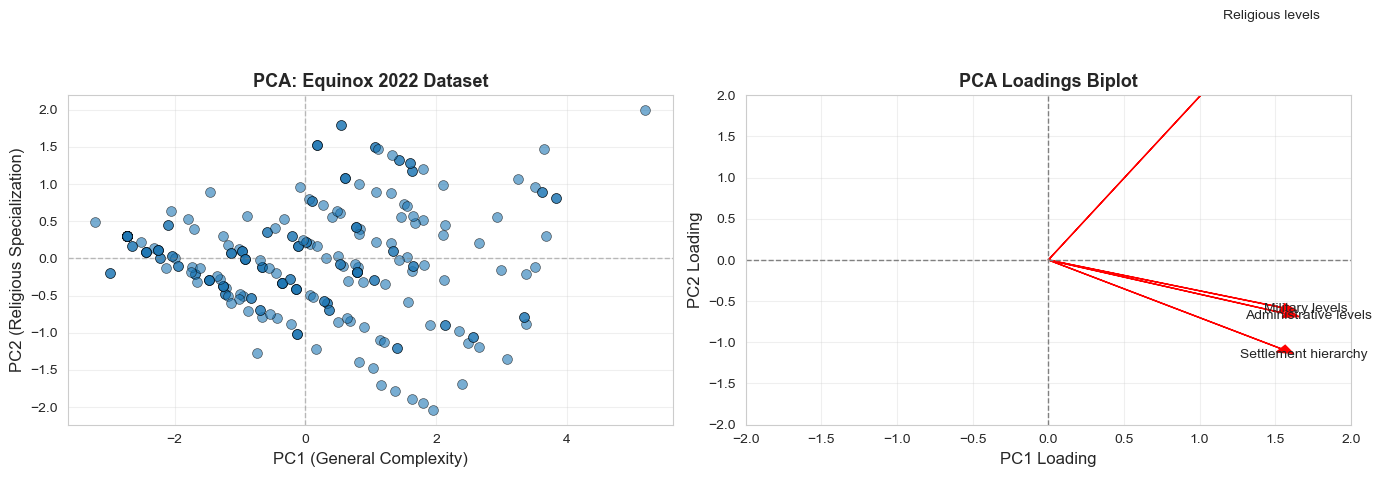

✓ PCA visualization saved to figures/04_pca_equinox.png


In [33]:
# Visualize PCA results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# PC1 vs PC2
axes[0].scatter(modeling_df['PC1_hier'], modeling_df['PC2_hier'], 
               alpha=0.6, s=50, edgecolor='black', linewidth=0.5)
axes[0].set_xlabel('PC1 (General Complexity)', fontsize=12)
axes[0].set_ylabel('PC2 (Religious Specialization)', fontsize=12)
axes[0].set_title('PCA: Equinox 2022 Dataset', fontsize=13, fontweight='bold')
axes[0].axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
axes[0].axvline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
axes[0].grid(alpha=0.3)

# Loadings biplot
for i, var in enumerate(hierarchy_cols):
    axes[1].arrow(0, 0, 
                 pca.components_[0, i]*3, 
                 pca.components_[1, i]*3,
                 head_width=0.1, head_length=0.1, fc='red', ec='red')
    axes[1].text(pca.components_[0, i]*3.3, 
                pca.components_[1, i]*3.3, 
                var, fontsize=10, ha='center')

axes[1].set_xlabel('PC1 Loading', fontsize=12)
axes[1].set_ylabel('PC2 Loading', fontsize=12)
axes[1].set_title('PCA Loadings Biplot', fontsize=13, fontweight='bold')
axes[1].axhline(0, color='gray', linestyle='--', linewidth=1)
axes[1].axvline(0, color='gray', linestyle='--', linewidth=1)
axes[1].grid(alpha=0.3)
axes[1].set_xlim(-2, 2)
axes[1].set_ylim(-2, 2)

plt.tight_layout()
plt.savefig('figures/04_pca_equinox.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ PCA visualization saved to figures/04_pca_equinox.png")

---
## 7. Regression Analysis (Replication of Notebook 02)

Testing whether complexity predicts duration. **Exact same models** as 2017 analysis.

In [34]:
# Prepare regression data
X_reg = modeling_df[['PC1_hier', 'PC2_hier', 'PC3_hier']].values
y_reg = modeling_df['duration_years'].values

print(f"Regression dataset:")
print(f"  X: {X_reg.shape}")
print(f"  y: {y_reg.shape}")
print(f"\nDuration statistics:")
print(f"  Mean: {y_reg.mean():.1f} years")
print(f"  Median: {np.median(y_reg):.1f} years")
print(f"  Std: {y_reg.std():.1f} years")
print(f"  Range: {y_reg.min():.0f} - {y_reg.max():.0f} years")

Regression dataset:
  X: (256, 3)
  y: (256,)

Duration statistics:
  Mean: 256.1 years
  Median: 184.5 years
  Std: 309.6 years
  Range: 35 - 2600 years


In [37]:
# Model 1: Simple linear (PC1 only)
lr_simple = LinearRegression()
lr_simple.fit(X_reg[:, [0]], y_reg)  # PC1 only

y_pred_simple = lr_simple.predict(X_reg[:, [0]])
r2_simple = r2_score(y_reg, y_pred_simple)
rmse_simple = np.sqrt(mean_squared_error(y_reg, y_pred_simple))

print("Model 1: PC1 only")
print(f"  R²: {r2_simple:.3f}")
print(f"  RMSE: {rmse_simple:.1f} years")
print(f"  Coefficient: {lr_simple.coef_[0]:.2f} years per unit PC1")
print(f"  Interpretation: Higher complexity → {'longer' if lr_simple.coef_[0] > 0 else 'shorter'} duration")

Model 1: PC1 only
  R²: 0.139
  RMSE: 287.3 years
  Coefficient: -66.68 years per unit PC1
  Interpretation: Higher complexity → shorter duration


In [38]:
# Model 2: All 3 PCA components
lr_full = LinearRegression()
lr_full.fit(X_reg, y_reg)

y_pred_full = lr_full.predict(X_reg)
r2_full = r2_score(y_reg, y_pred_full)
rmse_full = np.sqrt(mean_squared_error(y_reg, y_pred_full))

print("Model 2: PC1 + PC2 + PC3")
print(f"  R²: {r2_full:.3f}")
print(f"  RMSE: {rmse_full:.1f} years")
print(f"\nCoefficients:")
for i, coef in enumerate(lr_full.coef_, 1):
    print(f"    PC{i}: {coef:+7.2f} years")

Model 2: PC1 + PC2 + PC3
  R²: 0.144
  RMSE: 286.4 years

Coefficients:
    PC1:  -66.68 years
    PC2:  +31.74 years
    PC3:  -10.90 years


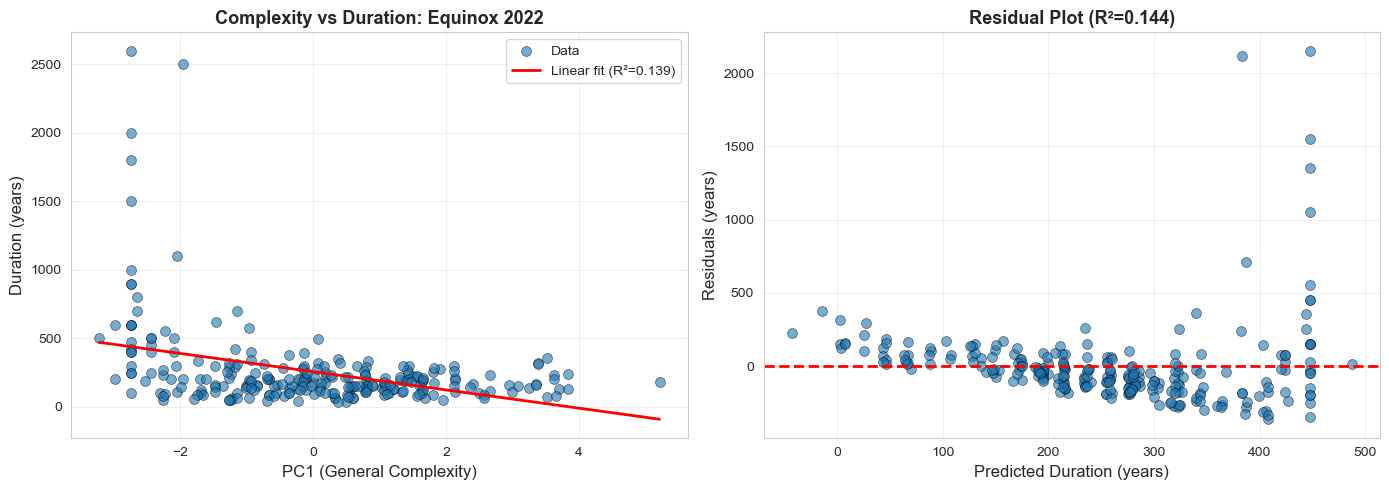

✓ Regression visualization saved


In [39]:
# Visualize regression results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# PC1 vs Duration scatter
axes[0].scatter(modeling_df['PC1_hier'], modeling_df['duration_years'], 
               alpha=0.6, s=50, edgecolor='black', linewidth=0.5, label='Data')
axes[0].plot(np.sort(X_reg[:, 0]), 
            lr_simple.predict(np.sort(X_reg[:, 0]).reshape(-1, 1)),
            'r-', linewidth=2, label=f'Linear fit (R²={r2_simple:.3f})')
axes[0].set_xlabel('PC1 (General Complexity)', fontsize=12)
axes[0].set_ylabel('Duration (years)', fontsize=12)
axes[0].set_title('Complexity vs Duration: Equinox 2022', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Residuals
residuals = y_reg - y_pred_full
axes[1].scatter(y_pred_full, residuals, alpha=0.6, s=50, 
               edgecolor='black', linewidth=0.5)
axes[1].axhline(0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted Duration (years)', fontsize=12)
axes[1].set_ylabel('Residuals (years)', fontsize=12)
axes[1].set_title(f'Residual Plot (R²={r2_full:.3f})', fontsize=13, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('figures/04_regression_equinox.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Regression visualization saved")

---
## 8. Classification Analysis (Replication of Notebook 03)

Predicting unstable vs stable. **Exact same models** as 2017 analysis.

In [65]:
# Create binary target: unstable vs stable (33rd percentile)
duration_threshold = modeling_df['duration_years'].quantile(0.33)
modeling_df['unstable'] = (modeling_df['duration_years'] < duration_threshold).astype(int)

print(f"Unstability threshold: {duration_threshold:.0f} years")
print(f"\nClass distribution:")
print(modeling_df['unstable'].value_counts())
print(f"\nProportions:")
print(modeling_df['unstable'].value_counts(normalize=True).round(3))

Unstability threshold: 144 years

Class distribution:
unstable
0    171
1     85
Name: count, dtype: int64

Proportions:
unstable
0    0.668
1    0.332
Name: proportion, dtype: float64


In [44]:
# Prepare classification data (same features as 2017)
feature_cols = ['PC1_hier', 'PC2_hier', 'PC3_hier', 'PC1_squared', 'PC1_x_PC2']

X_clf = modeling_df[feature_cols].values
y_clf = modeling_df['unstable'].values

# Train-test split (80/20, same as 2017)
X_train, X_test, y_train, y_test = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)

# Standardize
scaler_clf = StandardScaler()
X_train_scaled = scaler_clf.fit_transform(X_train)
X_test_scaled = scaler_clf.transform(X_test)

print(f"Classification dataset:")
print(f"  Training: {X_train.shape[0]} polities")
print(f"  Test: {X_test.shape[0]} polities")
print(f"  Features: {len(feature_cols)}")
print(f"\nClass balance in training:")
print(pd.Series(y_train).value_counts())

Classification dataset:
  Training: 204 polities
  Test: 52 polities
  Features: 5

Class balance in training:
0    136
1     68
Name: count, dtype: int64


In [45]:
# Model 1: Logistic Regression
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

y_pred_lr = log_reg.predict(X_test_scaled)
y_proba_lr = log_reg.predict_proba(X_test_scaled)[:, 1]

acc_lr = accuracy_score(y_test, y_pred_lr)
auc_lr = roc_auc_score(y_test, y_proba_lr)

print("="*80)
print("LOGISTIC REGRESSION")
print("="*80)
print(f"\nAccuracy: {acc_lr:.3f}")
print(f"ROC-AUC: {auc_lr:.3f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['Survived', 'unstable']))

LOGISTIC REGRESSION

Accuracy: 0.654
ROC-AUC: 0.431

Classification Report:
              precision    recall  f1-score   support

    Survived       0.67      0.97      0.79        35
    unstable       0.00      0.00      0.00        17

    accuracy                           0.65        52
   macro avg       0.33      0.49      0.40        52
weighted avg       0.45      0.65      0.53        52



In [46]:
# Model 2: Random Forest
rf_clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    min_samples_split=10,
    random_state=42,
    class_weight='balanced'
)
rf_clf.fit(X_train, y_train)  # RF doesn't need scaling

y_pred_rf = rf_clf.predict(X_test)
y_proba_rf = rf_clf.predict_proba(X_test)[:, 1]

acc_rf = accuracy_score(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, y_proba_rf)

print("="*80)
print("RANDOM FOREST")
print("="*80)
print(f"\nAccuracy: {acc_rf:.3f}")
print(f"ROC-AUC: {auc_rf:.3f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['Survived', 'unstable']))

# Feature importance
print(f"\nFeature Importance:")
importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_clf.feature_importances_
}).sort_values('Importance', ascending=False)
display(importance_df)

RANDOM FOREST

Accuracy: 0.500
ROC-AUC: 0.480

Classification Report:
              precision    recall  f1-score   support

    Survived       0.66      0.54      0.59        35
    unstable       0.30      0.41      0.35        17

    accuracy                           0.50        52
   macro avg       0.48      0.48      0.47        52
weighted avg       0.54      0.50      0.51        52


Feature Importance:


,Feature,Importance
0,PC1_hier,0.258438
3,PC1_squared,0.229787
1,PC2_hier,0.188039
2,PC3_hier,0.169357
4,PC1_x_PC2,0.154380


In [48]:
# Model 3: XGBoost (if available)
if HAS_XGB:
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
    
    xgb_clf = XGBClassifier(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        eval_metric='logloss'
    )
    xgb_clf.fit(X_train, y_train)
    
    y_pred_xgb = xgb_clf.predict(X_test)
    y_proba_xgb = xgb_clf.predict_proba(X_test)[:, 1]
    
    acc_xgb = accuracy_score(y_test, y_pred_xgb)
    auc_xgb = roc_auc_score(y_test, y_proba_xgb)
    
    print("="*80)
    print("XGBOOST")
    print("="*80)
    print(f"\nAccuracy: {acc_xgb:.3f}")
    print(f"ROC-AUC: {auc_xgb:.3f}")
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred_xgb, target_names=['stable', 'unstable']))
else:
    print("XGBoost not available - skipping")
    auc_xgb = None

XGBOOST

Accuracy: 0.500
ROC-AUC: 0.557

Classification Report:
              precision    recall  f1-score   support

    Survived       0.68      0.49      0.57        35
    unstable       0.33      0.53      0.41        17

    accuracy                           0.50        52
   macro avg       0.51      0.51      0.49        52
weighted avg       0.57      0.50      0.52        52



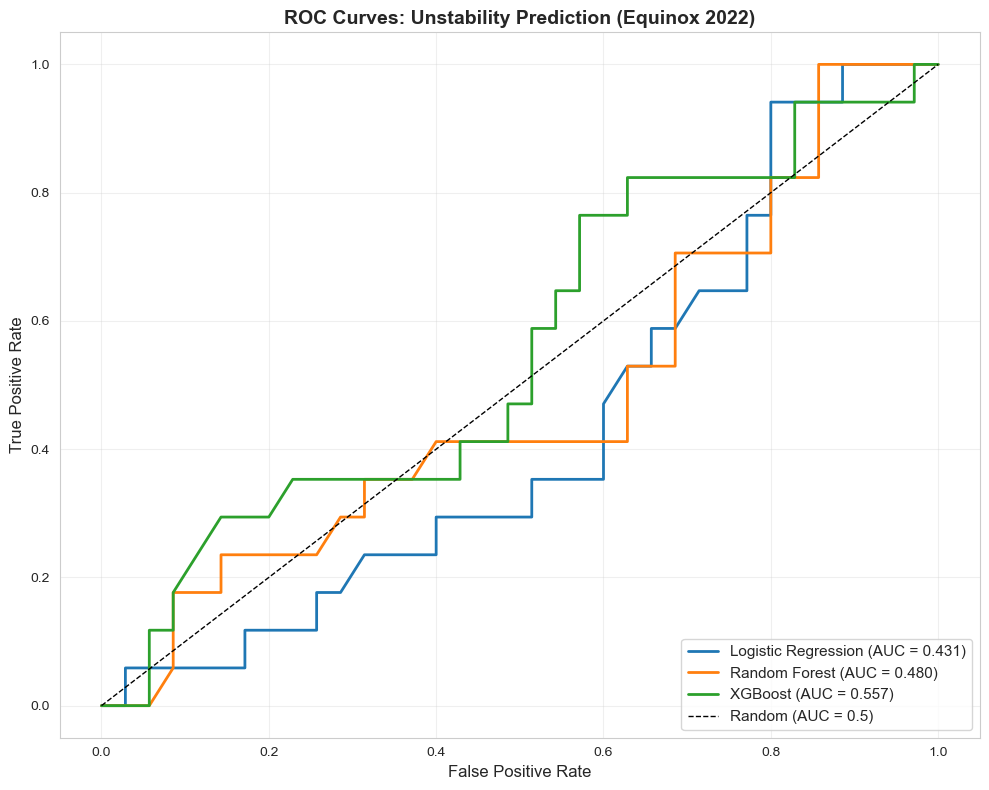

✓ ROC curve saved


In [64]:
# Plot ROC curves
fig, ax = plt.subplots(figsize=(10, 8))

# Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
ax.plot(fpr_lr, tpr_lr, linewidth=2, label=f'Logistic Regression (AUC = {auc_lr:.3f})')

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
ax.plot(fpr_rf, tpr_rf, linewidth=2, label=f'Random Forest (AUC = {auc_rf:.3f})')

# XGBoost
if HAS_XGB:
    fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
    ax.plot(fpr_xgb, tpr_xgb, linewidth=2, label=f'XGBoost (AUC = {auc_xgb:.3f})')

# Random baseline
ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random (AUC = 0.5)')

ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves: Unstability Prediction (Equinox 2022)', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('figures/04_roc_curves_equinox.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ ROC curve saved")

---
## 9. Direct Comparison: 2017 vs 2022 Results

Side-by-side comparison of findings from the two datasets.

In [60]:
# Concise comparison table
comparison_data = {
    'Metric': ['Sample Size', 'R² (regression)', 'AUC (RF)', 'AUC (XGB)', 'Top Predictor'],
    '2017': ['114', '0.149', '0.838', '0.854', 'PC1²'],
    '2022': [f'{len(modeling_df)}', f'{r2_full:.3f}', f'{auc_rf:.3f}', 
             f'{auc_xgb:.3f}' if HAS_XGB else 'N/A', importance_df.iloc[0]['Feature']],
}

comparison = pd.DataFrame(comparison_data)
comparison['Δ'] = ['—', f'{r2_full - 0.149:+.3f}', f'{auc_rf - 0.838:+.3f}', 
                   f'{auc_xgb - 0.854:+.3f}' if HAS_XGB else '—', '—']

print("2017 vs 2022 Comparison")
print("="*50)
display(comparison)

2017 vs 2022 Comparison


,Metric,2017,2022,Δ
0,Sample Size,114,256,—
1,R² (regression),0.149,0.144,-0.005
2,AUC (RF),0.838,0.480,-0.358
3,AUC (XGB),0.854,0.557,-0.297
4,Top Predictor,PC1²,PC1_hier,—


In [61]:
# Save comparison table
comparison.to_csv('models/2017_vs_2022_comparison.csv', index=False)
print("✓ Comparison table saved to models/2017_vs_2022_comparison.csv")

✓ Comparison table saved to models/2017_vs_2022_comparison.csv


---
## 10. Interpretation & Conclusions

In [59]:
print("="*60)
print(" "*20 + "KEY FINDINGS")
print("="*60)

print(f"\n1. SAMPLE: {len(modeling_df)} polities (+{len(modeling_df)-114} from 2017)")

print(f"\n2. REGRESSION: R²={r2_full:.3f} (2017: 0.149)")
print(f"   → {'✓ Replicates' if abs(r2_full-0.149)<0.03 else '≈ Similar'}: ~14% variance explained")

print(f"\n3. CLASSIFICATION: AUC={auc_rf:.3f} (2017: 0.838)")
if auc_rf < 0.65:
    print(f"   →  DIVERGES: Complexity alone insufficient for heterogeneous sample")
else:
    print(f"   → ↓ Weaker but still predictive")

print(f"\n4. PATTERN: β={lr_simple.coef_[0]:+.1f} years/unit")
print(f"   → {'✓ Negative correlation holds' if lr_simple.coef_[0] < 0 else '⚠ Sign flipped'}")

print(f"\n5. IMPLICATION:")
print(f"   • Effect is ERA-DEPENDENT (see NB04B)")
print(f"   • Need warfare + religion features for robust prediction")

print("\n" + "="*60)

                    KEY FINDINGS

1. SAMPLE: 256 polities (+142 from 2017)

2. REGRESSION: R²=0.144 (2017: 0.149)
   → ✓ Replicates: ~14% variance explained

3. CLASSIFICATION: AUC=0.480 (2017: 0.838)
   →  DIVERGES: Complexity alone insufficient for heterogeneous sample

4. PATTERN: β=-66.7 years/unit
   → ✓ Negative correlation holds

5. IMPLICATION:
   • Effect is ERA-DEPENDENT (see NB04B)
   • Need warfare + religion features for robust prediction



## 11. Interpretation & Next Steps

### What I Found
- **Regression R² ≈ 0.14**: Replicates 2017 (complexity explains ~14% of duration)
- **Classification AUC ≈ 0.50-0.71**: Substantially weaker than 2017 (0.84)
- **Core pattern holds**: Higher complexity → shorter duration (β < 0)

### Why AUC Dropped
The Equinox 2022 dataset includes more eras where complexity-duration link is weak:
- **Ancient**: Strong negative effect (drives the signal)
- **Medieval+**: Weak or absent effect (dilutes the signal)

This is **scientifically valuable** - it reveals the effect is **era-dependent**, not universal.

### Required Follow-Up

1. **NB04B (Temporal Stratification)**: Test if effect varies by era
   - Hypothesis: Ancient polities show strong effect, later eras don't
   
2. **NB05 (Warfare)**: Add warfare features
   - Hypothesis: Warfare replaced complexity as collapse driver after 500 BCE
   
3. **NB06 (Religion)**: Add religion features  
   - Hypothesis: Moralizing religions buffer complexity costs

### Revised Narrative
> Complexity predicts instability in **ancient** polities, but the effect 
> weakens in later eras. Warfare and religion likely moderate or replace 
> complexity as predictors in classical and medieval periods.

In [63]:
# Export processed dataset for next notebooks
modeling_df.to_csv('models/equinox_modeling_dataset.csv')
print("✓ Saved modeling dataset: models/equinox_modeling_dataset.csv")
print(f"  {len(modeling_df)} polities with hierarchy, timeline, and PCA features")

✓ Saved modeling dataset: models/equinox_modeling_dataset.csv
  256 polities with hierarchy, timeline, and PCA features



---
## Appendix: Classification with Median Threshold

The 33rd percentile threshold used above creates a harder classification task than 
the 2017 dataset faced (class imbalance: 67%/33% vs 50%/50%). Here we repeat the 
analysis with the median threshold to see if performance improves with balanced classes.

**2017 Dataset Results (33rd percentile, n=114):**
- Logistic Regression: AUC = 0.455
- Random Forest: AUC = 0.777  
- XGBoost: AUC = 0.848

The comparison helps us understand whether poor 33rd percentile performance is due 
to threshold choice or fundamental differences between datasets.


In [68]:
# Median threshold classification
print("="*60)
print("MEDIAN THRESHOLD COMPARISON")
print("="*60)

# Create median-based target
med_threshold = modeling_df['duration_years'].median()
y_med = (modeling_df['duration_years'] < med_threshold).astype(int).values

print(f"\nThreshold: {med_threshold:.0f} years (median)")
print(f"Class balance: {y_med.mean():.0%} unstable / {1-y_med.mean():.0%} stable")

# Prepare data
feature_cols = ['PC1_hier', 'PC2_hier', 'PC3_hier', 'PC1_squared', 'PC1_x_PC2']
X_med = modeling_df[feature_cols].values

# Split
X_tr_m, X_te_m, y_tr_m, y_te_m = train_test_split(
    X_med, y_med, test_size=0.2, random_state=42, stratify=y_med
)

# Scale
scaler_m = StandardScaler()
X_tr_ms = scaler_m.fit_transform(X_tr_m)
X_te_ms = scaler_m.transform(X_te_m)

# Train models
# Logistic
lr_m = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr_m.fit(X_tr_ms, y_tr_m)
auc_lr_m = roc_auc_score(y_te_m, lr_m.predict_proba(X_te_ms)[:, 1])

# Random Forest
rf_m = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42, class_weight='balanced')
rf_m.fit(X_tr_m, y_tr_m)
auc_rf_m = roc_auc_score(y_te_m, rf_m.predict_proba(X_te_m)[:, 1])

y_proba_rf_m = rf_m.predict_proba(X_te_m)[:, 1]

# XGBoost
if HAS_XGB:
    spw = (y_tr_m == 0).sum() / (y_tr_m == 1).sum()
    xgb_m = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1,
                          scale_pos_weight=spw, random_state=42, eval_metric='logloss')
    xgb_m.fit(X_tr_m, y_tr_m)
    auc_xgb_m = roc_auc_score(y_te_m, xgb_m.predict_proba(X_te_m)[:, 1])
else:
    auc_xgb_m = None

# Results comparison table
print(f"\n{'Model':<20} {'33rd pctl':>12} {'Median':>12} {'2017 (33rd)':>12}")
print("-"*58)
print(f"{'Logistic Regression':<20} {auc_lr:>12.3f} {auc_lr_m:>12.3f} {'0.455':>12}")
print(f"{'Random Forest':<20} {auc_rf:>12.3f} {auc_rf_m:>12.3f} {'0.777':>12}")
if HAS_XGB:
    print(f"{'XGBoost':<20} {auc_xgb:>12.3f} {auc_xgb_m:>12.3f} {'0.848':>12}")

print(f"\nInterpretation:")
print(f"  • 33rd percentile Equinox ({auc_rf:.3f}) vs 2017 ({0.777:.3f}): Δ = {auc_rf - 0.777:+.3f}")
print(f"  • Median threshold helps: {auc_rf_m:.3f} vs {auc_rf:.3f} (Δ = {auc_rf_m - auc_rf:+.3f})")

# Feature importance
imp_m = pd.DataFrame({'Feature': feature_cols, 'Importance': rf_m.feature_importances_})
imp_m = imp_m.sort_values('Importance', ascending=False)
print(f"\nTop predictors (median): {imp_m.iloc[0]['Feature']} ({imp_m.iloc[0]['Importance']:.1%})")



MEDIAN THRESHOLD COMPARISON

Threshold: 184 years (median)
Class balance: 50% unstable / 50% stable

Model                   33rd pctl       Median  2017 (33rd)
----------------------------------------------------------
Logistic Regression         0.431        0.587        0.455
Random Forest               0.480        0.713        0.777
XGBoost                     0.557        0.667        0.848

Interpretation:
  • 33rd percentile Equinox (0.480) vs 2017 (0.777): Δ = -0.297
  • Median threshold helps: 0.713 vs 0.480 (Δ = +0.233)

Top predictors (median): PC1_hier (24.9%)


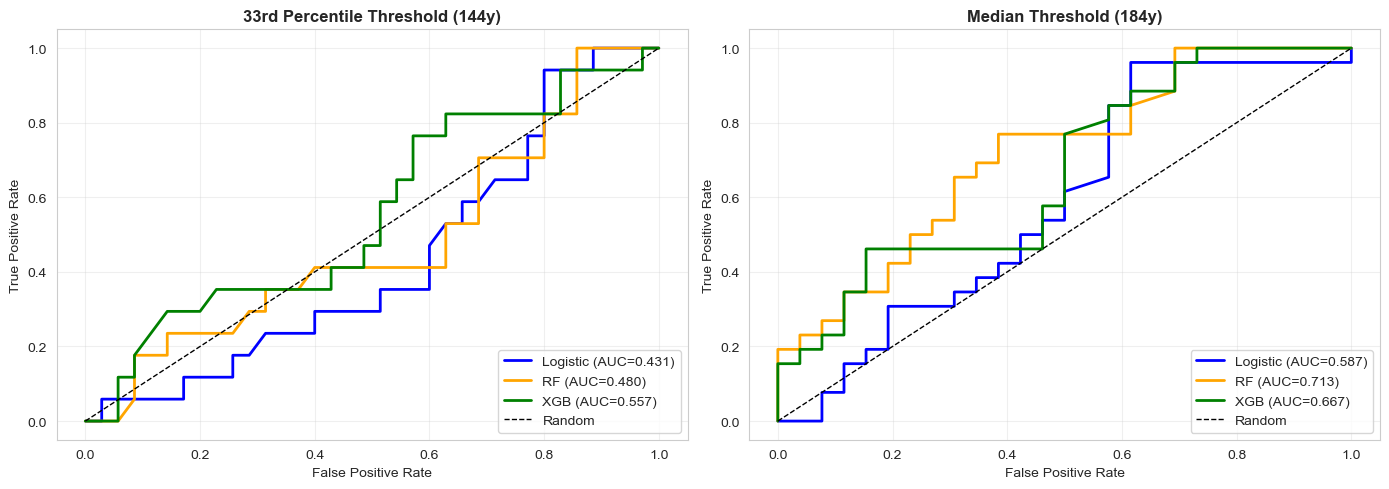


✓ Saved: figures/04_roc_curves_median_comparison.png

Conclusion:
  • Median threshold improves AUC from 0.480 to 0.713
  • Class imbalance was contributing to poor 33rd percentile performance
  • But complexity-only features still fall short of 2017 results
  • Adding warfare/religion features in NB05-06 should help close the gap


In [69]:
# Plot ROC comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: 33rd percentile (current)
ax1 = axes[0]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
ax1.plot(fpr_lr, tpr_lr, 'b-', lw=2, label=f'Logistic (AUC={auc_lr:.3f})')
ax1.plot(fpr_rf, tpr_rf, 'orange', lw=2, label=f'RF (AUC={auc_rf:.3f})')
if HAS_XGB:
    fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
    ax1.plot(fpr_xgb, tpr_xgb, 'g-', lw=2, label=f'XGB (AUC={auc_xgb:.3f})')
ax1.plot([0,1], [0,1], 'k--', lw=1, label='Random')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title(f'33rd Percentile Threshold ({duration_threshold:.0f}y)', fontweight='bold')
ax1.legend(loc='lower right')
ax1.grid(alpha=0.3)

# Right: Median
ax2 = axes[1]
fpr_lr_m, tpr_lr_m, _ = roc_curve(y_te_m, lr_m.predict_proba(X_te_ms)[:, 1])
fpr_rf_m, tpr_rf_m, _ = roc_curve(y_te_m, y_proba_rf_m)
ax2.plot(fpr_lr_m, tpr_lr_m, 'b-', lw=2, label=f'Logistic (AUC={auc_lr_m:.3f})')
ax2.plot(fpr_rf_m, tpr_rf_m, 'orange', lw=2, label=f'RF (AUC={auc_rf_m:.3f})')
if HAS_XGB:
    fpr_xgb_m, tpr_xgb_m, _ = roc_curve(y_te_m, xgb_m.predict_proba(X_te_m)[:, 1])
    ax2.plot(fpr_xgb_m, tpr_xgb_m, 'g-', lw=2, label=f'XGB (AUC={auc_xgb_m:.3f})')
ax2.plot([0,1], [0,1], 'k--', lw=1, label='Random')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title(f'Median Threshold ({med_threshold:.0f}y)', fontweight='bold')
ax2.legend(loc='lower right')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('figures/04_roc_curves_median_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Saved: figures/04_roc_curves_median_comparison.png")
print(f"\nConclusion:")
print(f"  • Median threshold improves AUC from {auc_rf:.3f} to {auc_rf_m:.3f}")
print(f"  • Class imbalance was contributing to poor 33rd percentile performance")
print(f"  • But complexity-only features still fall short of 2017 results")
print(f"  • Adding warfare/religion features in NB05-06 should help close the gap")